In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import pickle
xgb.set_config(verbosity=1) #turn down info

from sklearn import tree
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data.head(5)

,weight,height,closing,open_00_02,open_02_04,open_04_06,open_06_08,open_08_10,open_10_12,open_12_14,...,cuisine_y_Regional,cuisine_y_Seafood,cuisine_y_Vietnamese,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,smoking,age,target
0,69,1.77,12,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,32,2
1,69,1.77,24,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,32,0
2,69,1.77,20,0,0,0,0,0,1,1,...,0,1,0,0,0,0,1,0,32,1
3,69,1.77,23,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,32,2
4,69,1.77,23,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,32,2


In [3]:
def split_data(data_x: np.ndarray, data_y: np.ndarray):
    
    ordering = np.arange(data_x.shape[0])
    np.random.shuffle(ordering)
    data_x = data_x[ordering]
    data_y = data_y[ordering]
    
    valid_start = int(len(data_x) * 0.7)
    test_start = int(len(data_x) * 0.9)
    
    train_set = (data_x[:valid_start], data_y[:valid_start])
    valid_set = (data_x[valid_start:test_start], data_y[valid_start:test_start])
    test_set = (data_x[test_start:], data_y[test_start:])
    
    return train_set, valid_set, test_set

In [4]:
y = np.array(data['target'])
x = np.array(data.drop(['target'], axis=1))

train_set, valid_set, test_set = split_data(x,y)

x_train = train_set[0]
y_train = train_set[1]

x_val = valid_set[0]
y_val = valid_set[1]

x_test = test_set[0]
y_test = test_set[1]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2055, 134)
(587, 134)
(294, 134)


# Bagging on decision trees:

In [5]:
def create_bootstrap_data():
    bootstrap_ids = np.random.randint(0, len(x_train), size=len(x_train))
    return x_train[bootstrap_ids,:], y_train[bootstrap_ids]

In [6]:
def build_classifier(data_set, labels, max_depth):
    random_state= np.random.randint(low=0, high=1e5)
    decision_tree = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split=3, min_samples_leaf=2, random_state=random_state)
    decision_tree.fit(data_set, labels)
    return decision_tree

In [7]:
def build_classifiers(cases, max_depth):
    classifiers = []
    for case in range(cases):
        bootstrap_set, bootstrap_labels = create_bootstrap_data()
        classifier = build_classifier(bootstrap_set, bootstrap_labels, max_depth)
        classifiers.append(classifier)
    return classifiers

In [8]:
def vote(classifiers, test_data):
    output = []
    for classifier in classifiers:
        output.append(classifier.predict(test_data))
    output = np.array(output)
    predicted = []
    for i in range(len(test_data)):
        classified = output[:, i]
        counts = np.bincount(classified)
        predicted.append(np.argmax(counts))
    return predicted

## Grid search:

In [9]:
m_arr = np.arange(10, 100, 10)
depth_arr = np.linspace(6, 18, 13)

for m in m_arr:
    for max_depth in depth_arr:
        classifiers = build_classifiers(m, max_depth)
        predicted = vote(classifiers, x_val)
        accuracy = accuracy_score(y_val, predicted)
        print("Accuracy on validation set: {:.2f} using m={:} and depth = {:}".format(accuracy*100, m, max_depth))

Accuracy on validation set: 81.26 using m=10 and depth = 6.0
Accuracy on validation set: 83.48 using m=10 and depth = 7.0
Accuracy on validation set: 83.99 using m=10 and depth = 8.0
Accuracy on validation set: 87.22 using m=10 and depth = 9.0
Accuracy on validation set: 86.71 using m=10 and depth = 10.0
Accuracy on validation set: 87.39 using m=10 and depth = 11.0
Accuracy on validation set: 88.93 using m=10 and depth = 12.0
Accuracy on validation set: 88.42 using m=10 and depth = 13.0
Accuracy on validation set: 89.61 using m=10 and depth = 14.0
Accuracy on validation set: 89.44 using m=10 and depth = 15.0
Accuracy on validation set: 89.78 using m=10 and depth = 16.0
Accuracy on validation set: 88.59 using m=10 and depth = 17.0
Accuracy on validation set: 89.78 using m=10 and depth = 18.0
Accuracy on validation set: 78.88 using m=20 and depth = 6.0
Accuracy on validation set: 83.82 using m=20 and depth = 7.0
Accuracy on validation set: 85.18 using m=20 and depth = 8.0
Accuracy on val

In [10]:
m = 100
max_depth = 12
classifiers = build_classifiers(m, max_depth)
predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on validation set: 90.12 %


In [11]:
m = 25
max_depth = 13
classifiers = build_classifiers(m, max_depth)
predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on validation set: 89.95 %


# FINAL EVALUATION OF THE MODEL: Bagging on decision trees

In [12]:
m = 25
max_depth = 13
classifiers = build_classifiers(m, max_depth)

predicted = vote(classifiers, x_train)
accuracy = accuracy_score(y_train, predicted)
print("Accuracy on trainig set: {:.2f} %".format(accuracy*100))

predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))


predicted = vote(classifiers, x_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on trainig set: 97.27 %
Accuracy on validation set: 88.59 %
Accuracy on validation set: 94.56 %


# XGBClassifier using xgboost library

In [13]:
n_estimators =100
max_depth = 15
min_child_weight = 2

classifier = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, min_child_weight=min_child_weight)
classifier.fit(x_train, y_train)

[18:00:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
output = classifier.predict(x_val)
target = y_val
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.4f} %".format(accuracy*100))


Accuracy on testing set: 92.6746 %


## Feature importance

In [15]:
feature_important = classifier.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

features = list(data.columns)
name_features = []
for k in keys:
    index = int(k[1:])
    name_features.append(features[index])


df_feature_important = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
df_feature_important['name_features']=name_features
df_feature_important.head(15)

,score,name_features
f0,982,drinker_casual drinker
f2,942,cuisine_x_Mexican
f1,889,weight
f133,554,religion_Christian
f128,343,cuisine_y_Japanese
f7,316,smoking
f131,289,color_black
f123,275,closing
f129,249,parking_lot_yes
f9,188,height


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

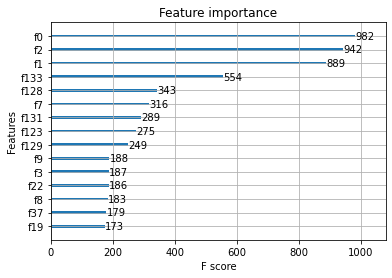

In [16]:
xgb.plot_importance(classifier, importance_type='weight',max_num_features=15 )

In [17]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

features = list(data.columns)
name_features = []
for k in keys:
    index = int(k[1:])
    name_features.append(features[index])


df_feature_important = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
df_feature_important['name_features']=name_features
df_feature_important.head(15)

,score,name_features
f27,6.196689,drinker_casual drinker
f104,4.503568,cuisine_x_Mexican
f29,3.529492,weight
f126,2.600444,religion_Christian
f115,2.301103,cuisine_y_Japanese
f54,2.245126,smoking
f40,2.208852,color_black
f111,2.188123,closing
f36,1.962631,parking_lot_yes
f133,1.656195,height


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

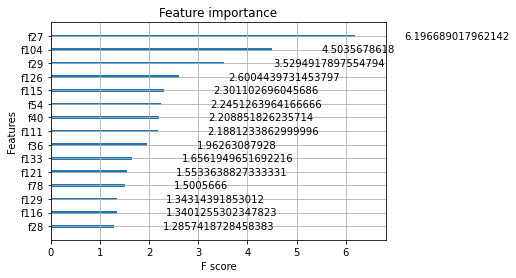

In [18]:
xgb.plot_importance(classifier, importance_type='gain',max_num_features=15 )

## Save model

In [19]:
file_name = "xgb_model.pkl"

# save
pickle.dump(classifier, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# FINAL EVALUATION OF THE MODEL: XGBoost

In [20]:
xgb_model_loaded = pickle.load(open(file_name, "rb"))

output = xgb_model_loaded.predict(x_train)
target = y_train
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.4f} %".format(accuracy*100))

output = xgb_model_loaded.predict(x_val)
target = y_val
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.4f} %".format(accuracy*100))

output = xgb_model_loaded.predict(x_test)
target = y_test
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on testing set: {:.4f} %".format(accuracy*100))


Accuracy on testing set: 99.6107 %

Accuracy on testing set: 92.6746 %

Accuracy on testing set: 95.2381 %
